# 석정로 M20518

## Datasets
---
iPhone 12에서 직접 촬영 후 적용해 보았지만, 일정거리의 촛점에 따라 같은 카메라로 인식되지 않는 문제가 발생하여 Kaggle의 IEEE's Signal Processing Society - Camera Model Identification 데이터셋을 사용하였습니다. IEEE's Signal Processing Society 데이터셋은 모두 jpeg 포멧을 가지며, 모델별로 같은 기기로 촬영되었습니다.

![Dataset](./images/kaggle.png)


## Importing & Defining Utilities
---

In [68]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score

from fingerprints import getFingerprint as extract_fp
from functions import PCE, WienerInDFT, crosscorr

In [101]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[:1024, :1024]
    return img


def shift_hue(img, degree):
    hsv = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    h = (h + degree) % 180
    hsv = cv2.merge([h.astype('uint8'), s, v])
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def shift_hue_randomly(img, theta_options=list(range(0, 180, 30))):
    """options에서 랜덤하게 hue shifting"""
    theta = np.random.choice(theta_options)
    return shift_hue(img, theta), theta


def make_fingerprint(imgs):
    """패턴 추출"""
    if type(imgs) == list:
        if len(imgs) == 1:
            imgs = [imgs]
    if type(imgs) == np.ndarray:
        if imgs.ndim == 3:
            imgs = [imgs]
    patterns = extract_fp(imgs)
    sigmas = np.std(patterns, axis=(0, 1))
    patterns = [WienerInDFT(patterns[..., c], sigmas[c]) for c in range(3)]
    return patterns


def visualize_imgs(*args):
    """시각화"""
    fig, axes = plt.subplots(ncols=len(args), figsize=(16, len(args) * 8))
    ax = axes.ravel()

    for i, (img, title) in enumerate(args):
        ax[i].imshow(img)
        ax[i].set_title(title)
        ax[i].axis('off')

    plt.show()


def evaluate(fingerprint, imgs_shifted, delta_s=45):
    """RMSE 및 Accuracy 평가

    Args:
        fingerprint: 특정 디바이스의 레퍼런스 패턴
        imgs_shifted: 시프트된 이미지 목록
    """
    thetas = []
    thetas_optimal = []
    for img, lbl in imgs_shifted:
        theta_optimal, _, _ = estimate_optimal_theta(fingerprint, img, delta_s)
        thetas.append(lbl)
        thetas_optimal.append(theta_optimal)
    error = mean_squared_error(thetas, thetas_optimal, squared=False)
    accuracy = accuracy_score(thetas, thetas_optimal)
    return error, accuracy, thetas, thetas_optimal


### Calculating correlation

$I_{c}^{(k)}$: Untampered Image

$n_{c}(\theta)$: noise residual from $I_{c}^{(k)}$

$P_{c}$: Reference Pattern

$\rho_{c}(\theta) = corr(n_{c}(\theta), P_{c})$

$corr(n_{c}(\theta), P_{c})$ 계산은 과제에 포함된 함수(getFingerprint)를 그대로 사용하였습니다.

In [3]:
def calculate_corr(fingerprint, fingerprint_ref):
    return [PCE(crosscorr(fingerprint[ch], fingerprint_ref[ch]))[0]['PCE'] for ch in range(3)]

### Estimating optimal $\theta$

$\hat{\theta}=argmax\,_{\theta}[\sum_{c}(\rho_{c}(\theta))]$

식에 따라 입력된 이미지에 $\Delta{s}$만큼 hue shifting을 적용해가며 $\rho_{c}(\theta)$가 최대가 되는 $\hat{\theta}$를 찾습니다.

In [30]:
def estimate_optimal_theta(fingerprint_ref, tampered_img, delta_s = 10):
    thetas = list(range(0, 180, delta_s)) # 시프트할 각도들; start:0, end: 180, step=delta_s
    imgs = [shift_hue(tampered_img, -theta) for theta in thetas] # 시프트 적용된 이미지들
    fingerprints = [make_fingerprint(img) for img in imgs] # 시프트된 이미지마다 지문 추출
    
    theta_optimal = 0
    corr_best = 0
    for i, fingerprint in enumerate(fingerprints): # 각도별로
        corrs = calculate_corr(fingerprint, fingerprint_ref) # 채널별 corr
        corr_total = sum(corrs) # 채널별 corr을 모두 더함$
        if corr_total > corr_best:
            corr_best = corr_total
            theta_optimal = thetas[i]
    
    return theta_optimal, imgs, thetas

## Preparing Images
---

In [102]:
imgs_ip4_origin = [load_img(fr'images\iPhone-4s\(iP4s){i+1}.jpg') for i in range(100)] # iPhone 4의 원본 이미지
imgs_ip6_origin = [load_img(fr'images\iPhone-6\(iP6){i+1}.jpg') for i in range(100)] # iPhone 6의 원본 이미지
imgs_ip4_shifted = [shift_hue_randomly(img) for img in imgs_ip4_origin] # iPhone 4의 시프트된 이미지
imgs_ip6_shifted = [shift_hue_randomly(img) for img in imgs_ip6_origin] # iPhone 4의 시프트된 이미지

### Extracting Fingerprints

In [105]:
fingerprint_ip4 = make_fingerprint(imgs_ip4_origin[:16])
fingerprint_ip6 = make_fingerprint(imgs_ip6_origin[:16])

## Analysis
---
### iPhone 4의 레퍼런스 패턴

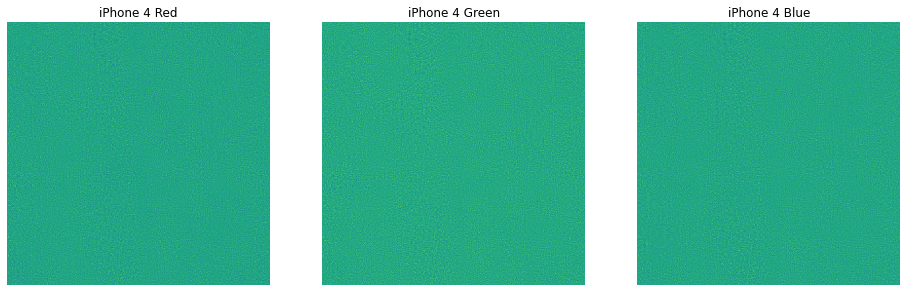

In [18]:
visualize_imgs((fingerprint_ip4[0], 'iPhone 4 Red'), (fingerprint_ip4[1], 'iPhone 4 Green'), (fingerprint_ip4[2], 'iPhone 4 Blue'))

### iPhone 6의 레퍼런스 패턴

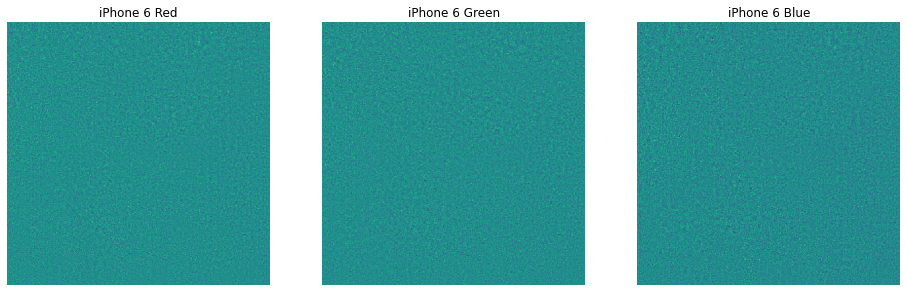

In [19]:
visualize_imgs((fingerprint_ip6[0], 'iPhone 6 Red'), (fingerprint_ip6[1], 'iPhone 6 Green'), (fingerprint_ip6[2], 'iPhone 6 Blue'))

### $N_{p}=16, \Delta{s}=45$일때, 원본 이미지와 $-Estimated\, \hat{\theta}$ 적용한 이미지

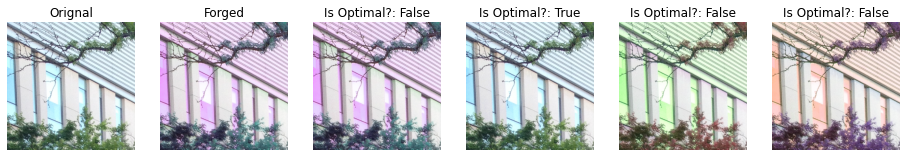

In [34]:
idx = 50
img_shifted, ground_truth = imgs_ip4_shifted[idx] # 시프트된 이미지, 적용된 theta
theta_optimal, imgs, thetas = estimate_optimal_theta(fingerprint_ip4, img_shifted, 45) # return: estimated theta, 중간 과정의 이미지, 테스트된 theta들

args = [(imgs_ip4_origin[idx], "Orignal"), (img_shifted, "Forged")]
args += [(img, f"Is Optimal?: {theta == theta_optimal}") for img, theta in zip(imgs, thetas)]
visualize_imgs(*args)

$\hat{\theta}$가 $\theta$와 같으면 True로 표현됩니다.

### $N_{p}=16, \Delta{s}=5$일때, 16개 이미지를 추정한 결과

레퍼런스 패턴을 추출한 이미지에서는 낮은 error를 보이지만, 추출하지 않은 이미지를 사용시 좋지 않은 결과나왔습니다..

In [106]:
error, accuracy, thetas, thetas_optimal = evaluate(
    fingerprint_ip4, imgs_ip4_shifted[16:32], 5)

In [109]:
print(f"# Summary(err: {error})")
for theta, theta_optimal in zip(thetas, thetas_optimal):
    print(f"gt: {theta}, est: {theta_optimal}")

# Summary(err: 73.28241603549927)
gt: 120, est: 60
gt: 30, est: 150
gt: 60, est: 65
gt: 0, est: 0
gt: 30, est: 30
gt: 150, est: 150
gt: 0, est: 175
gt: 60, est: 80
gt: 30, est: 20
gt: 60, est: 125
gt: 150, est: 40
gt: 60, est: 55
gt: 60, est: 0
gt: 90, est: 150
gt: 90, est: 90
gt: 0, est: 115
